# L0 Compressed Sensing Optimization with l0core

This notebook demonstrates how to use the `l0core` package for L0 optimization in compressed sensing applications. The package provides a modular implementation of various algorithms presented in the original L0opt.ipynb notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from skimage.transform import resize

# Import l0core modules
from l0core.transforms import (
    haar2_transform_flat, 
    inverse_haar2_transform_from_flat,
    dct2_transform_flat,
    inverse_dct2_transform_flat
)
from l0core.hamiltonians import (
    hamiltonian_h_prime_single_var,
    calculate_h_prime_relaxed,
    calculate_user_hamiltonian
)
from l0core.penalties import (
    penalty_terms_single_var,
    total_loss_function_single_var
)
from l0core.solvers import (
    solve_continuous_relaxation_single_var,
    solve_continuous_relaxation_sgd,
    solve_alternating_relaxed_h_prime,
    solve_alternating_mip,
    solve_cosamp
)
from l0core.qubo_solvers import (
    solve_alternating_relaxed_mip_external_qubo,
    # solve_qubo_relaxedsolve_alternating_relaxed_mip_external_qubo_R_CG,
    solve_l0_hybrid_R_CG_x_QUBO
)

# For visualization
%matplotlib inline

## Loading and Preparing Data

First, we'll load some example data for testing compressed sensing algorithms.

Fetching MNIST dataset...
MNIST dataset loaded.
Using image label: 6, size (28, 28)


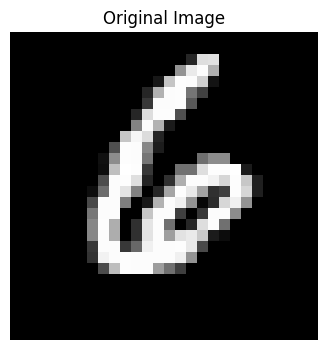

In [5]:
# Load MNIST dataset as an example
# mnist = fetch_openml('mnist_784', version=1)
# sample_image = mnist.data[0].reshape((28, 28))
use_smaller_image  = False

# --- 1. Load and Prepare MNIST Data ---
print("Fetching MNIST dataset...")
try:
    mnist_path = './mnist_784_cache' 
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff', data_home=mnist_path)
    X_mnist, y_mnist_labels = mnist["data"], mnist["target"]
    print("MNIST dataset loaded.")
except Exception as e:
    print(f"Failed to fetch MNIST: {e}. Using random data instead.")
    dummy_N_pixels = (28*28) if not use_smaller_image else (20*20) # Adjusted for consistency
    X_mnist = np.random.rand(100, dummy_N_pixels) * 255 
    y_mnist_labels = np.random.randint(0, 9, 100).astype(str)

image_index = 13 
original_image_full_res = X_mnist[image_index].reshape(28, 28)
if use_smaller_image:
    target_size = (20, 20) 
    original_image = resize(original_image_full_res, target_size, anti_aliasing=True, preserve_range=True)
    if original_image.max() <= 1.0: original_image = original_image * 255.0
else: target_size = (28,28); original_image = original_image_full_res
original_image = np.clip(original_image, 0, 255)
image_shape = original_image.shape
print(f"Using image label: {y_mnist_labels[image_index]}, size {image_shape}")

# Display the sample image
plt.figure(figsize=(4, 4))
plt.imshow(original_image_full_res, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Create a smaller image for faster processing
# small_image = resize(sample_image, (16, 16), anti_aliasing=True)
# plt.figure(figsize=(4, 4))
# plt.imshow(original_image, cmap='gray')
# plt.title('Resized Image (16x16)')
# plt.axis('off')
# plt.show()

Image shape: (28, 28)
Total coefficients: 784
Non-zero coefficients (>0.01): 222


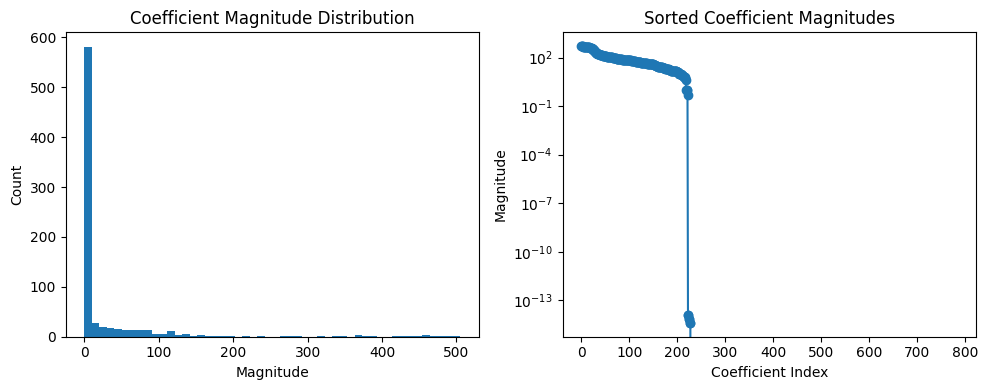

In [6]:
# Apply Haar wavelet transform
coeffs_flat, coeffs_shape, coeff_slices = haar2_transform_flat(original_image)

# Print some statistics
print(f"Image shape: {original_image.shape}")
print(f"Total coefficients: {len(coeffs_flat)}")
print(f"Non-zero coefficients (>0.01): {np.sum(np.abs(coeffs_flat) > 0.01)}")

# Visualize coefficient distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.abs(coeffs_flat), bins=50)
plt.title('Coefficient Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.plot(sorted(np.abs(coeffs_flat), reverse=True), 'o-')
plt.title('Sorted Coefficient Magnitudes')
plt.xlabel('Coefficient Index')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.tight_layout()
plt.show()

## Setting up Compressed Sensing Problem

Now we'll create a compressed sensing problem by creating a random sensing matrix 
and generating measurements.

In [13]:
# Parameters
N = len(coeffs_flat)     # Number of coefficients
M = N // 2               # Number of measurements (25% of original size)
np.random.seed(42)

# Generate random sensing matrix
A_cs = np.random.normal(0, 1/np.sqrt(M), (M, N))

# Generate measurements
y_cs = A_cs @ coeffs_flat

print(f"Original dimension: {N}")
print(f"Measurement dimension: {M}")
print(f"Compression ratio: {N/M:.2f}x")

Original dimension: 784
Measurement dimension: 392
Compression ratio: 2.00x


## Solving with JAX-based Continuous Relaxation

We'll use the JAX-based solver from the l0core package.


--- Starting JAX L0 Optimization (SGD with Momentum) ---
N_r_dim (signal)=784, M_k_dim (measurements)=392, Lambda=0.1
LR=0.005, Iterations=3000, Batch Size=78, Momentum=0.9
Penalty (x(1-x)=0)=10.0
Iter     0: Loss = -2652.6958, ReconErrTerm = 3011012.2500, Binary_err = 2.5566e+01, Sparsity (x>0.5) = 363
Iter   300: Loss = -2857227.0000, ReconErrTerm = 156665.6875, Binary_err = 1.5842e+00, Sparsity (x>0.5) = 502
Iter   600: Loss = -2844258.7500, ReconErrTerm = 169642.1719, Binary_err = 1.2169e+00, Sparsity (x>0.5) = 461
Iter   900: Loss = -2753338.0000, ReconErrTerm = 260565.5469, Binary_err = 6.9204e-01, Sparsity (x>0.5) = 498
Iter  1200: Loss = -2706973.2500, ReconErrTerm = 306924.3125, Binary_err = 1.1649e+00, Sparsity (x>0.5) = 459
Iter  1500: Loss = -2810928.7500, ReconErrTerm = 202975.3906, Binary_err = 1.1020e+00, Sparsity (x>0.5) = 473
Iter  1800: Loss = -2668205.7500, ReconErrTerm = 345697.0938, Binary_err = 8.8977e-01, Sparsity (x>0.5) = 465
Iter  2100: Loss = -2782810.0000, 

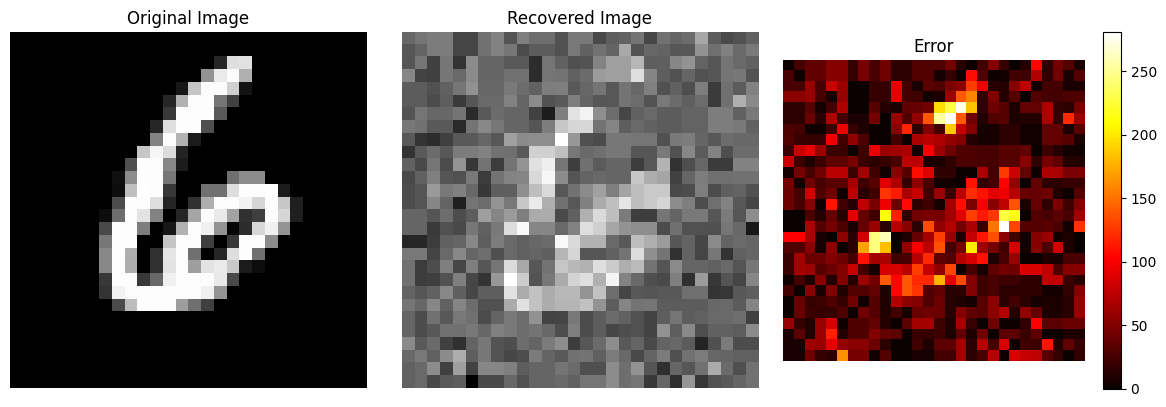

In [14]:
# Parameters
lambda_param = 0.1      # L0 regularization weight
num_iterations = 3000
learning_rate = 0.005

# Solve using JAX-based continuous relaxation
R_solution, x_solution, loss_history = solve_continuous_relaxation_sgd(
    A_cs.T,                  # Note: Our function expects the transpose
    y_cs,
    lambda_param,
    N,                      
    M,                       
    learning_rate=learning_rate,
    num_iterations=num_iterations,
    penalty_coeff=10.0,      # Binary constraint penalty coefficient
    verbose=True
)

# Apply solution
recovered_coeffs = R_solution * (x_solution > 0.5)  # Threshold x at 0.5

# Recover the image
recovered_image = inverse_haar2_transform_from_flat(
    recovered_coeffs, coeffs_shape, coeff_slices
)

# Count non-zeros
num_nonzeros = np.sum(x_solution > 0.5)
print(f"Number of non-zero coefficients: {num_nonzeros} ({num_nonzeros/N:.2%})")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recovered_image, cmap='gray')
plt.title('Recovered Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(original_image - recovered_image), cmap='hot')
plt.title('Error')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# Parameters
lambda_param = 0.1      # L0 regularization weight
num_iterations = 3000
learning_rate = 0.005

# Solve using JAX-based continuous relaxation
R_solution, x_solution, loss_history = solve_cosamp(
    A_cs,                 
    y_cs,
    lambda_mip=0.0001,
    target_sparsity=N//4,
    N_signal=N,
    M_measure=M,
    num_outer_iter=50,
    num_R_iter=None,
    num_sigma_iter=None,
    initial_R=None,
    initial_sigma=None,
    verbose=True)

# Apply solution
recovered_coeffs = R_solution * (x_solution > 0.5)  # Threshold x at 0.5

# Recover the image
recovered_image = inverse_haar2_transform_from_flat(
    recovered_coeffs, coeffs_shape, coeff_slices
)

# Count non-zeros
num_nonzeros = np.sum(x_solution > 0.5)
print(f"Number of non-zero coefficients: {num_nonzeros} ({num_nonzeros/N:.2%})")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recovered_image, cmap='gray')
plt.title('Recovered Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(original_image - recovered_image), cmap='hot')
plt.title('Error')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

## Solving with QUBO Approach

If the QCI Dirac3 solver is available, we can also use the QUBO approach.

In [ ]:
try:
    # Prepare QUBO
    qubo_result = prep_qubo_relaxed_hamiltonian(
        A_cs.T,
        y_cs,
        lambda_param=lambda_param
    )
    
    # Solve using hybrid method (try relaxed QUBO first, then final optimization)
    hybrid_result = hybrid_solver(
        A_cs.T,
        y_cs,
        lambda_param=lambda_param,
        qubo_result=qubo_result,
        num_samples=10,
        sgd_steps=500
    )
    
    # Extract results
    R_hybrid, x_hybrid, loss_final = hybrid_result
    recovered_coeffs_qubo = R_hybrid * x_hybrid
    
    # Recover image
    recovered_image_qubo = inverse_haar2_transform_from_flat(
        recovered_coeffs_qubo, coeffs_shape, coeff_slices
    )
    
    # Count non-zeros
    num_nonzeros_qubo = np.sum(x_hybrid > 0)
    print(f"Number of non-zero coefficients (QUBO): {num_nonzeros_qubo} ({num_nonzeros_qubo/N:.2%})")
    
    # Visualize
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(small_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(recovered_image_qubo, cmap='gray')
    plt.title('QUBO Recovered Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(small_image - recovered_image_qubo), cmap='hot')
    plt.title('QUBO Error')
    plt.axis('off')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"QUBO solving failed: {e}")
    print("This might be because QCI's Dirac3 solver is not available.")
    print("You can still use the other solvers in the l0core package.")

## Comparison with Other Methods

Let's compare our approach with other standard methods like Lasso and OMP.

OMP target sparsity (n_nonzero_coefs): 196 (estimated true: 222)


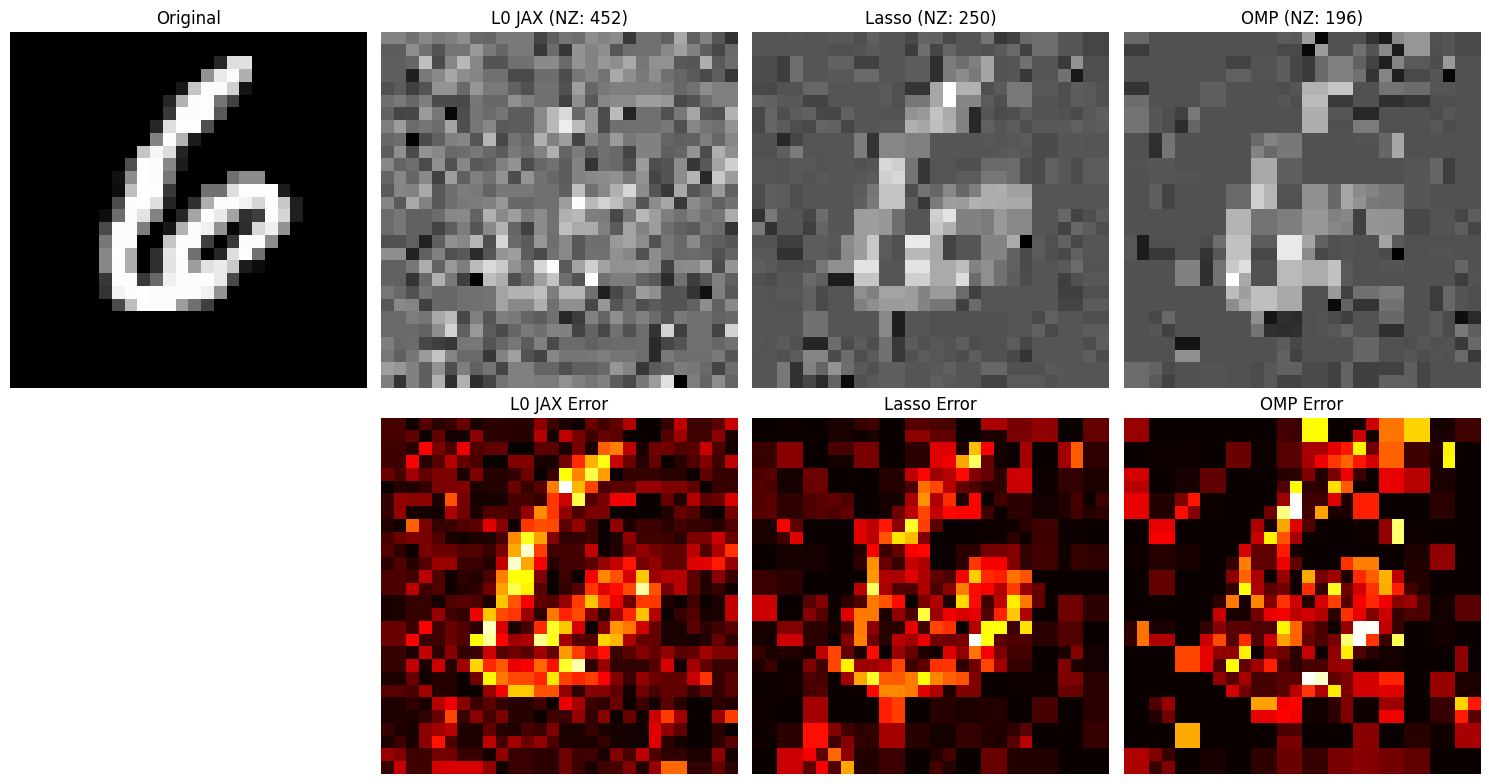

Mean Squared Error:
L0 JAX:  6904.206015
Lasso:   2359.979622
OMP:     4118.062250


In [15]:
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit

# Lasso
lasso = Lasso(alpha=0.001, max_iter=5000)
lasso.fit(A_cs, y_cs)
lasso_coeffs = lasso.coef_
lasso_image = inverse_haar2_transform_from_flat(
    lasso_coeffs, coeffs_shape, coeff_slices
)
lasso_nonzeros = np.sum(np.abs(lasso_coeffs) > 1e-6)

# OMP
# Estimate true sparsity for OMP (e.g., number of significant Haar coefficients)
true_sparsity_estimate = np.sum(np.abs(coeffs_flat) > 1e-2) # Threshold can be tuned
omp_n_nonzero_coefs = max(1, int(true_sparsity_estimate * 1.2)) # Target a bit more than estimate
omp_n_nonzero_coefs = min(omp_n_nonzero_coefs, M, N) # Cannot exceed M or N
print(f"OMP target sparsity (n_nonzero_coefs): {omp_n_nonzero_coefs} (estimated true: {true_sparsity_estimate})")
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=omp_n_nonzero_coefs, fit_intercept=False)
omp.fit(A_cs, y_cs)
omp_coeffs = omp.coef_
omp_image = inverse_haar2_transform_from_flat(
    omp_coeffs, coeffs_shape, coeff_slices
)
omp_nonzeros = np.sum(np.abs(omp_coeffs) > 1e-6)

# Visualize
plt.figure(figsize=(15, 8))

plt.subplot(2, 4, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(recovered_image, cmap='gray')
plt.title(f'L0 JAX (NZ: {num_nonzeros})')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(lasso_image, cmap='gray')
plt.title(f'Lasso (NZ: {lasso_nonzeros})')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(omp_image, cmap='gray')
plt.title(f'OMP (NZ: {omp_nonzeros})')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(np.abs(original_image - recovered_image), cmap='hot')
plt.title('L0 JAX Error')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(np.abs(original_image - lasso_image), cmap='hot')
plt.title('Lasso Error')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(np.abs(original_image - omp_image), cmap='hot')
plt.title('OMP Error')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print error metrics
l0_error = np.mean((original_image - recovered_image)**2)
lasso_error = np.mean((original_image - lasso_image)**2)
omp_error = np.mean((original_image - omp_image)**2)

print(f"Mean Squared Error:")
print(f"L0 JAX:  {l0_error:.6f}")
print(f"Lasso:   {lasso_error:.6f}")
print(f"OMP:     {omp_error:.6f}")

In [21]:
N_signal = 10
M_measurements = 7
sparsity_true = 5 # Number of non-zero elements in true signal
lambda_sparsity_param = 1.8 # Regularization parameter

np.random.seed(42)

# 1. Generate a true sparse signal s_true
s_true = np.zeros(N_signal)
non_zero_indices = np.random.choice(N_signal, sparsity_true, replace=False)
# s_true[non_zero_indices] = np.random.randn(sparsity_true) * 5 # Some non-zero values
s_true[non_zero_indices] = (np.random.randn(sparsity_true) * 3) + np.copysign(5, np.random.randn(sparsity_true))
print(f"True sparse signal (s_true) [{np.sum(s_true!=0)} non-zeros]:\n{s_true}")

# 2. Generate a random sensing matrix A
A_sensing_matrix = np.random.randn(M_measurements, N_signal)
# Normalize columns of A (optional, but can help with conditioning)
# A_sensing_matrix = A_sensing_matrix / np.linalg.norm(A_sensing_matrix, axis=0, keepdims=True)
print(f"\nSensing matrix A shape: {A_sensing_matrix.shape}")

# 3. Compute measurements y
y_measurements = A_sensing_matrix @ s_true
# Add some noise (optional)
# noise_level = 0.01
# y_measurements += noise_level * np.random.randn(M_measurements)
print(f"Measurement vector y shape: {y_measurements.shape}")

# 4. Call the hybrid solver
print("\n--- Calling L0 Hybrid Solver ---")

# Initial guess (optional, can be None)
R_initial_guess = np.random.randn(N_signal) * 0.1
x_initial_guess = (np.abs(R_initial_guess) > 0.05).astype(float)
# R_initial_guess = None
# x_initial_guess = None

import time
"""
start_time = time.time()
R_recovered, x_recovered = solve_l0_hybrid_R_CG_x_QUBO(
    A_matrix=A_sensing_matrix,
    y_vector=y_measurements,
    lambda_val=lambda_sparsity_param,
    N_signal=N_signal,
    num_outer_iter=5, # Increase for more complex problems
    num_R_iter_cg=15,  # Max CG iterations per R-update
    cg_tolerance=1e-8,
    qubo_num_samples=20 if EQC_MODELS_AVAILABLE else 5, # More samples if using real solver
    qubo_relaxation_schedule=1,
    initial_R=R_initial_guess,
    initial_x=x_initial_guess,
    verbose=True
)
end_time = time.time()
print(f"\nSolver finished in {end_time - start_time:.2f} seconds.")
"""
R_recovered, x_recovered = None, None

######--------------------------------
sigma_initial_guess = ((x_initial_guess) > 0.5).astype(int)
print('sigma init: ', sigma_initial_guess)

R_mip, sigma_mip, history_H_mip = solve_alternating_mip(
    A_cs_matrix=A_sensing_matrix, 
    y_cs_vec=y_measurements, 
    lambda_mip=lambda_sparsity_param,
    N_signal=N_signal, 
    M_measure=M_measurements,
    num_outer_iter=5, 
    num_R_iter=10, 
    num_sigma_iter=10, # Fewer iterations for quicker test
    initial_R=R_initial_guess, 
    initial_sigma=sigma_initial_guess,
    verbose=True
)
######--------------------------------

# 5. Results
# s_reconstructed = R_recovered * x_recovered
s_reconstructed = R_mip * sigma_mip
x_recovered = sigma_mip
print('s_reconstructed: ', s_reconstructed)

print(f"\nTrue s:          {np.array2string(s_true, precision=3, floatmode='fixed')}")
# print(f"Recovered R:     {np.array2string(R_recovered, precision=3, floatmode='fixed')}")
# print(f"Recovered x:     {np.array2string(x_recovered, precision=3, floatmode='fixed')}")
print(f"Recovered sigma:     {sigma_mip}")
print(f"Recovered R_mip:     {R_mip}")
print(f"Reconstructed s: {np.array2string(s_reconstructed, precision=3, floatmode='fixed')}")

mse_s = np.mean((s_true - s_reconstructed)**2)
mse_y = np.mean((y_measurements - A_sensing_matrix @ s_reconstructed)**2)
recovered_sparsity = np.sum(x_recovered > 0.5)

print(f"\nMSE (s_true vs s_reconstructed): {mse_s:.4e}")
print(f"MSE (y_true vs A@s_reconstructed): {mse_y:.4e}")
print(f"True sparsity: {sparsity_true}, Recovered sparsity: {recovered_sparsity}")

# Check if support is recovered
true_support = set(np.where(np.abs(s_true) > 1e-6)[0])
recovered_support = set(np.where(x_recovered > 0.5)[0])
print(f"True support: {true_support}")
print(f"Recovered support: {recovered_support}")
if true_support == recovered_support:
    print("SUCCESS: Exact support recovery!")
else:
    print("INFO: Support not exactly recovered.")
    print(f"  Missing from true: {true_support - recovered_support}")
    print(f"  Extra in recovered: {recovered_support - true_support}")

# 6. Comparison with L1 Lasso and OMP on synthetic data
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit

# L1 Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(A_sensing_matrix, y_measurements)
lasso_coeffs = lasso_model.coef_
s_lasso = lasso_coeffs
mse_lasso = np.mean((s_true - s_lasso)**2)
support_lasso = set(np.where(np.abs(s_lasso) > 1e-6)[0])
print(f"\nLasso Recovered s: {np.array2string(s_lasso, precision=3, floatmode='fixed')}")
print(f"MSE Lasso: {mse_lasso:.4e}, Support: {support_lasso}")

# OMP
omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=sparsity_true)
omp_model.fit(A_sensing_matrix, y_measurements)
omp_coeffs = omp_model.coef_
s_omp = omp_coeffs
mse_omp = np.mean((s_true - s_omp)**2)
support_omp = set(np.where(np.abs(s_omp) > 1e-6)[0])
print(f"\nOMP Recovered s: {np.array2string(s_omp, precision=3, floatmode='fixed')}")
print(f"MSE OMP: {mse_omp:.4e}, Support: {support_omp}")

True sparse signal (s_true) [5 non-zeros]:
[ 3.42449058 -1.96845415  0.          0.          0.          3.2573656
  0.         -6.7141405  -4.16287612  0.        ]

Sensing matrix A shape: (7, 10)
Measurement vector y shape: (7,)

--- Calling L0 Hybrid Solver ---
sigma init:  [0 0 1 0 0 1 0 0 1 0]

--- Starting Alternating MIP Solver (Original Binary Sigma) ---
Lambda_MIP=1.8, OuterIter=20, R_iter=3, Sigma_iter=3
MIP Iter   0: Sparsity = 3, Hamiltonian_orig = -46.3859
MIP Iter   2: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter   4: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter   6: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter   8: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter  10: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter  12: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter  14: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter  16: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter  18: Sparsity = 2, Hamiltonian_orig = -50.1076
MIP Iter  19: Sparsity

## Conclusion

This notebook demonstrates how to use the `l0core` package for L0-regularized compressed sensing. 
The modular structure makes it easy to experiment with different transforms, solvers, and parameters 
while maintaining a clean codebase.

Key benefits of using the modular l0core package:
1. Clean separation of concerns (transforms, solvers, penalties, etc.)
2. Easy experimentation with different algorithms
3. Better code reusability across projects
4. Improved maintainability and extensibility